# ARIMA MODEL 


##### Step 1. Import modules and load dataset

In [1]:
#Import required Libraries
import numpy as np, pandas as pd
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from numpy import log
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import sqrt
from pandas import read_csv
import multiprocessing as mp

### Just to remove warnings to prettify the notebook. 
import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv('NKG Historical Data.csv',delimiter=",", thousands=',')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,05/31/2024,24400.0,24500.0,24700.0,24300.0,4.89M,0.21%
1,05/30/2024,24350.0,24400.0,24650.0,24150.0,6.99M,-1.62%
2,05/29/2024,24750.0,25250.0,25600.0,24750.0,8.00M,-1.20%
3,05/28/2024,25050.0,25250.0,25250.0,24850.0,4.43M,0.60%
4,05/27/2024,24900.0,24600.0,24900.0,24600.0,4.31M,0.40%
...,...,...,...,...,...,...,...
1308,03/07/2019,4934.5,5217.0,5217.0,4934.5,1.29M,-3.59%
1309,03/06/2019,5118.5,5223.6,5256.5,5118.5,697.98K,-2.01%
1310,03/05/2019,5223.6,5328.7,5387.9,5223.6,2.48M,0.00%
1311,03/04/2019,5223.6,5256.5,5289.3,5125.1,1.92M,3.25%


In [3]:
# Determine the data types
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1313 entries, 0 to 1312
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      1313 non-null   object 
 1   Price     1313 non-null   float64
 2   Open      1313 non-null   float64
 3   High      1313 non-null   float64
 4   Low       1313 non-null   float64
 5   Vol.      1313 non-null   object 
 6   Change %  1313 non-null   object 
dtypes: float64(4), object(3)
memory usage: 71.9+ KB


In [4]:
# Convert data
df['Date'] = pd.to_datetime(df['Date'])

##### Step 2. Selecting attribute 

In [5]:
df = df[['Price']]
df = df.dropna() 
df = df.reset_index(drop=True) 
df

,Price
0,24400.0
1,24350.0
2,24750.0
3,25050.0
4,24900.0
...,...
1308,4934.5
1309,5118.5
1310,5223.6
1311,5223.6


##### Step 3. Split the dataset into train, test, validate

In [6]:
# Calculate the number of samples for each set
train_size = int(0.70 * len(df))
test_size = int(0.30 * len(df))

# Split data into sets
train_data = df[:train_size]
test_data = df[train_size:]

# Check the size of each set
print("Train data size:", len(train_data))
print("Test data size:", len(test_data))

Train data size: 919
Test data size: 394


##### Step 4. Process of training the model

In [7]:
#ADF test
r = adfuller(train_data, autolag='AIC', regression='ct')
print('ADF Statistic: {}'.format(r[0]))
print('p-value: {}'.format(r[1]))
print('Critical Values:')
for key, value in r[4].items():
    print('\t{}: {}'.format(key, value))

ADF Statistic: -1.614233705755331
p-value: 0.7868089633197815
Critical Values:
	1%: -3.9688083159702927
	5%: -3.4153523645639834
	10%: -3.129911839051655


In [8]:
print('ADF Statistic for 1st Order Differencing')
result = adfuller(train_data.diff().dropna())
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))

ADF Statistic for 1st Order Differencing
ADF Statistic: -6.592038
p-value: 0.000000
Critical Values:
	1%: -3.438
	5%: -2.865
	10%: -2.568


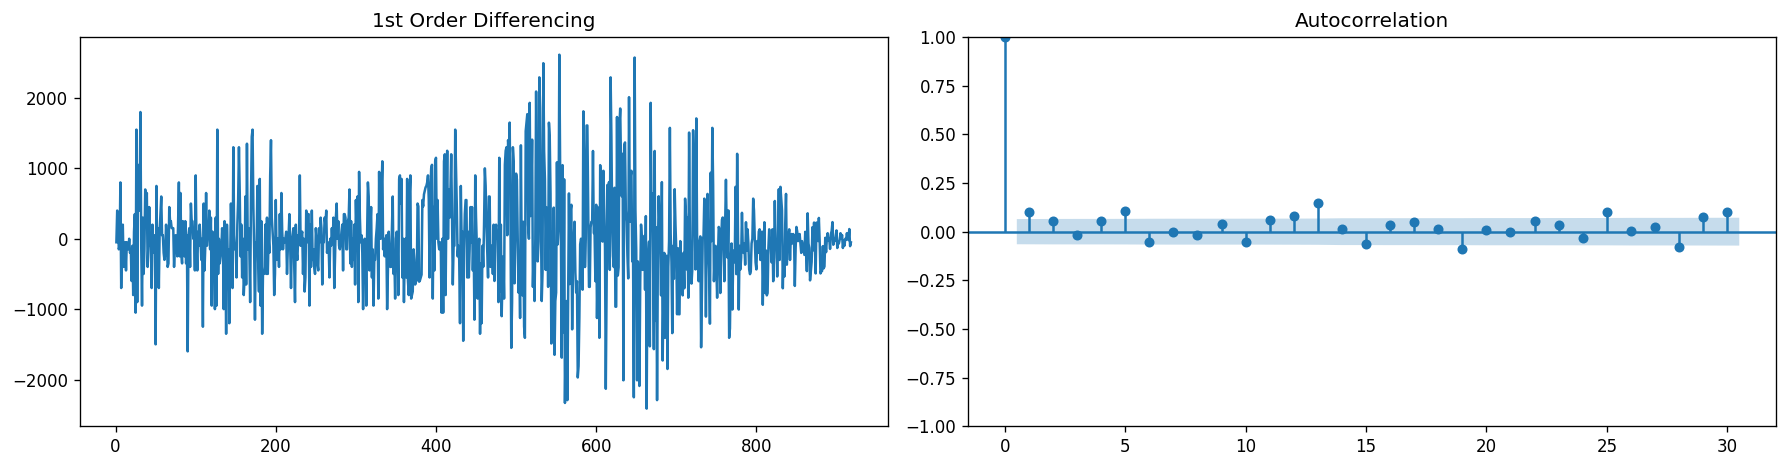

In [9]:
plt.rcParams.update({'figure.figsize': (15, 4), 'figure.dpi': 120})

# 1st Differencing
fig, ax = plt.subplots(1, 2)  # Create a figure with 1 row and 2 columns
ax[0].plot(train_data.diff()); ax[0].set_title('1st Order Differencing')
plot_acf(train_data.diff().dropna(), ax=ax[1])  # Use ax[1] for ACF plot

plt.tight_layout() 
plt.show()

In [10]:
!pip install pmdarima

In [11]:
# Process of Training
x_train = np.array(train_data.index).reshape(-1, 1)
y_train = np.array(train_data['Price'])

# Train model
from pmdarima.arima import auto_arima
model = auto_arima(y_train, d=1, trace=True, error_action='ignore', suppress_warnings=True)

# Fit the model
model.fit(y_train)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=14624.466, Time=8.34 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=14636.527, Time=0.03 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=14630.481, Time=0.07 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=14631.236, Time=0.16 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=14635.325, Time=0.02 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=14632.623, Time=1.13 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=14631.792, Time=1.19 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=14626.410, Time=2.20 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=14611.040, Time=4.15 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=14633.033, Time=0.21 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=14624.356, Time=2.84 sec
 ARIMA(2,1,4)(0,0,0)[0] intercept   : AIC=14600.336, Time=2.19 sec
 ARIMA(1,1,4)(0,0,0)[0] intercept   : AIC=14631.322, Time=0.55 sec
 ARIMA(3,1,4)(0,0,0)[0] intercept   : AIC=14610.394, Time=2.38 sec
 ARIMA(2,1,5)(0,0,0

ARIMA(order=(2, 1, 4), scoring_args={}, suppress_warnings=True,
      with_intercept=False)

In [12]:
# Process of Testing 
x_test = np.array(test_data.index).reshape(-1, 1)
y_test = np.array(test_data['Price'])
y_pred = model.predict(n_periods=len(y_test))

##### Step 5. Evaluate the accuracy of test sets

In [13]:
# RMSE
test_rmse = np.sqrt(np.mean((y_pred - y_test)**2))
print('RMSE:', test_rmse)

RMSE: 1155.0248510489428


In [14]:
# MAPE
mape_test = np.mean(np.abs((y_test - y_pred) / y_test)) * 100
print('MAPE:', mape_test)

MAPE: 24.906543866184954


In [15]:
# MAE
mae_test = np.mean(np.abs(y_test - y_pred))
print("MAE:", mae_test)

MAE: 1019.8235749025821


##### Step 6. Forecasting 

In [16]:
# Process of creating an index to predict the next 90 days
last_index = df.index[-1]
last_data = pd.RangeIndex(start=last_index, stop=last_index+90, step=1)

# Creating an array for the next 90 days
x_next_90_days = np.array(range(last_index+1, last_index+91)).reshape(-1, 1)

# Predicting the next 90 days
y_next_90_days = model.predict(n_periods=len(x_next_90_days))

# Printing out the predicted closing prices for the next 90 days
print('Predicted closing prices for the next 90 days:')
print(y_next_90_days)

Predicted closing prices for the next 90 days:
[5417.32183532 5433.37591466 5460.95525511 5446.09906013 5416.34188594
 5425.84570426 5456.82497095 5452.80912399 5421.57343905 5420.13451969
 5450.68032728 5457.37774144 5428.42082129 5416.81377526 5443.3557858
 5459.38577824 5435.98892452 5416.14199542 5435.77848843 5458.73858704
 5443.34734621 5418.05170167 5428.85403422 5455.65919567 5449.64182189
 5422.17538552 5423.3611095  5450.64449137 5454.19053462 5427.90534907
 5419.86688024 5444.39160385 5456.55480524 5434.47849869 5418.67195402
 5437.7047979  5456.57726252 5441.07473357 5419.78975222 5431.39490971
 5454.38480055 5446.91660011 5422.96081632 5426.18357256 5450.35792309
 5451.35841551 5427.69843261 5422.6232367  5445.07194148 5453.95495627
 5433.3584741  5421.04152104 5439.21850227 5454.50275907 5439.22390204
 5421.51509878 5433.51776636 5453.05068941 5444.59317268 5423.87455635
 5428.63209062 5449.8802341  5448.86193056 5427.73794037 5425.09128605
 5445.45951143 5451.58874694 54

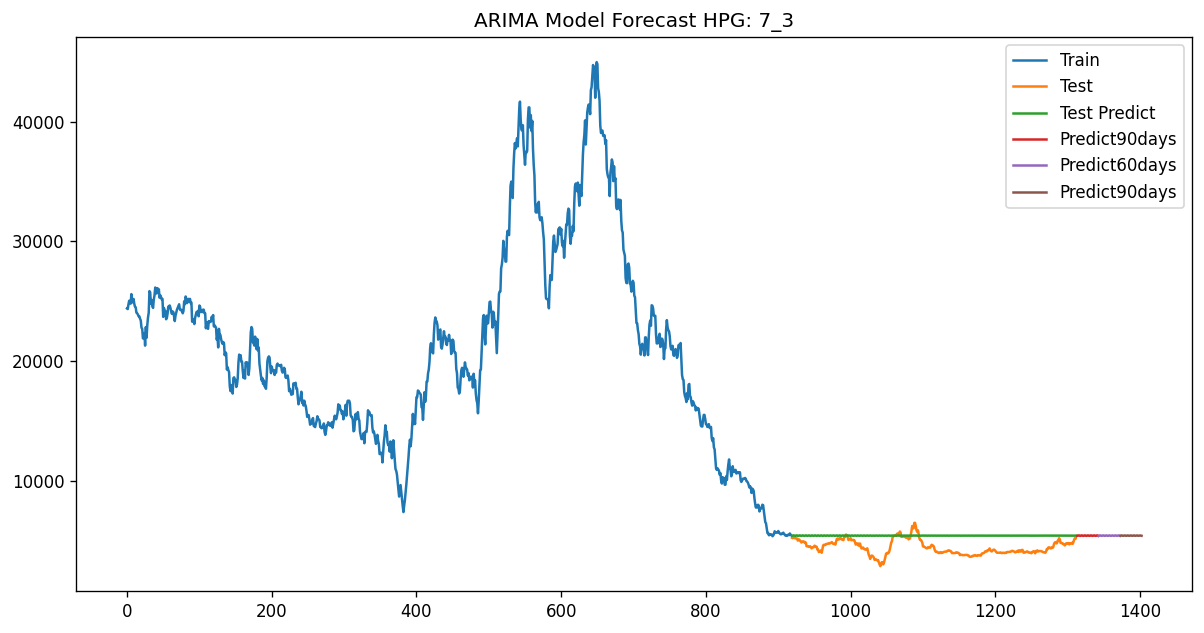

In [23]:
# Tạo DataFrame cho dự đoán test
test_predict_df = pd.DataFrame(y_pred, columns=['Price'])
test_predict_index = range(len(train_data), len(train_data)+ len(y_pred)) 
test_predict_df.index = test_predict_index

# Tạo DataFrame cho dữ liệu huấn luyện và kiểm tra
train_data_df = df[:train_size][['Price']]
test_data_df = df[train_size:train_size + test_size][['Price']]

next_90_days_index = np.arange(len(df), len(df) + 90)
next_90_days_df = pd.DataFrame(y_next_90_days, index=next_90_days_index, columns=['Price'])

# Vẽ đồ thị
plt.figure(figsize=(12, 6))

# Vẽ dữ liệu huấn luyện
plt.plot(train_data_df, label='Train')

# Vẽ dữ liệu kiểm tra
plt.plot(test_data_df, label='Actual Test')

# Vẽ dự báo test predict
plt.plot(test_predict_df.index, test_predict_df['Price'], label='Test Predict')

# Vẽ dự báo 

plt.plot(next_90_days_df.index[:30], next_90_days_df['Price'][:30], label='Next 30 days')
plt.plot(next_90_days_df.index[30:60], next_90_days_df['Price'][30:60], label='Next 60 days')
plt.plot(next_90_days_df.index[60:], next_90_days_df['Price'][60:], label='Next 90 days')

# Thêm chú thích và hiển thị đồ thị
plt.title('ARIMA Model Forecast HPG: 7_3')
plt.legend(['Train', 'Test', 'Test Predict', 'Predict90days', 'Predict60days', 'Predict90days'])
plt.show()

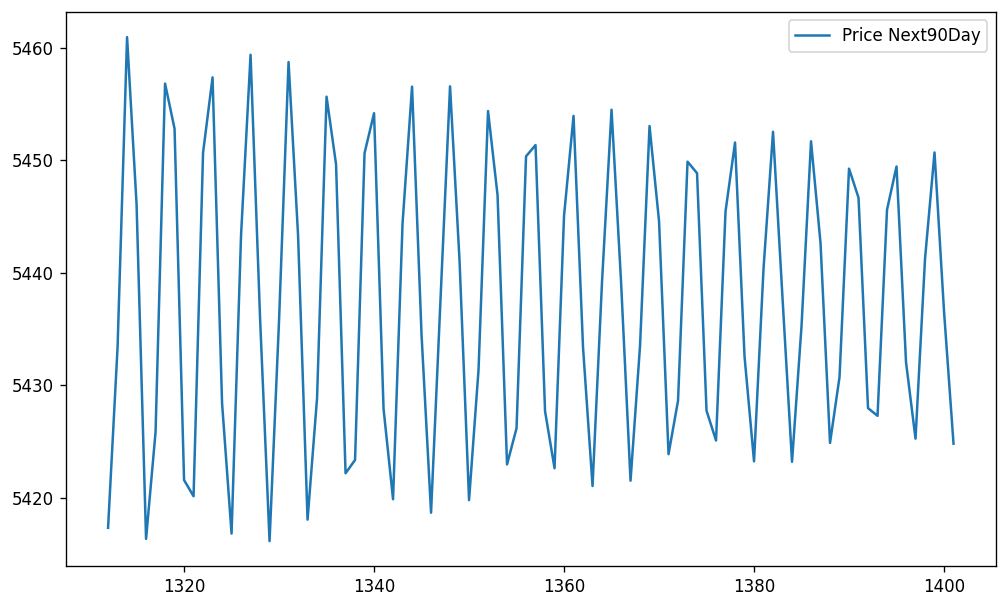

In [24]:
plt.figure(figsize=(10, 6))
plt.plot(last_data,y_next_90_days)
plt.legend(['Price Next90Day'])
plt.show()